In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from rasterio.transform import xy
import pandas as pd
from rasterio.windows import Window

from rtc_seq_dataset import localize_one_rtc, despeckle_one

# Burst data

In [ ]:
# parquet file was generated in A_searching_burst_data

df_rtc_meta = pd.read_parquet('validation_bursts_all_new100_v3_filtered.parquet')
df_rtc_meta.head()

,jpl_burst_id,rtc_s1_vv_url,rtc_s1_vh_url,acq_datetime,geometry
0,T001-000055-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-16T18:03:17Z,"{'coordinates': [[[1.5084 9.7685], [2.2771 9...."
1,T001-000055-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-04T18:03:17Z,"{'coordinates': [[[1.50767 9.76872], [2.27641 ..."
2,T001-000055-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-22T18:03:17Z,"{'coordinates': [[[1.50831 9.76901], [2.27697 ..."
3,T001-000055-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-10T18:03:17Z,"{'coordinates': [[[1.50791 9.76869], [2.27669 ..."
4,T001-000055-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-29T18:03:17Z,"{'coordinates': [[[1.50569 9.76872], [2.27482 ..."


In [2]:
import requests
from io import BytesIO
from __future__ import annotations
from pathlib import Path

import numpy as np
import rasterio


def _download_to_array(url: str):
    if url.startswith("http"):
        r = requests.get(url, stream=True)      # .netrc creds are used
        r.raise_for_status()
        src = BytesIO(r.content)
    else:
        src = url
    with rasterio.open(src) as ds:
        return ds.read(1).astype(np.float32), ds.profile


def _localize_one_rtc(urls, out_root: Path) -> Path:
    vv_url, vh_url = urls
    local_fn = Path(vv_url).name
    burst_id = local_fn.split("_")[3]
    out_dir  = out_root / burst_id
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{local_fn[:-7]}_stack.tif"

    if out_path.exists():
        return out_path

    arrs, profiles = zip(*(_download_to_array(u) for u in (vv_url, vh_url)))
    stack   = np.stack(arrs, axis=0)
    profile = profiles[0].copy()
    profile.update(count=2)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(stack)
    return out_path

def _download_one(url: str | Path, *_unused) -> tuple[np.ndarray, dict]:
    """
    Legacy API: still returns (array, profile) so existing callers work.
    Extra args are ignored (they used to be `dst_dir`).
    """
    return _download_to_array(str(url))


# ---------------------------------------------------------------------
# 3.  main burst-localiser – no tmp folders, no file handles to pickle
# ---------------------------------------------------------------------
def _localize_one_rtc(
    urls: tuple[str | Path, str | Path],
    out_root: Path,
    *,
    with_despeckling: bool = True,
    preserve_nans: bool = True,
) -> Path:
    """
    Stack VV & VH RTC rasters into a 2-band GeoTIFF
    <out_root>/<burst_id>/<basename>_stack.tif
    """
    vv_url, vh_url = urls
    local_fn = Path(vv_url).name
    burst_id = local_fn.split("_")[3]

    out_dir  = out_root / burst_id
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"{local_fn[:-7]}_stack.tif"

    if out_path.exists():               # already done
        return out_path

    # ── 1. fetch both polarisations straight into RAM ────────────────
    arrs, profiles = zip(*(_download_to_array(str(u)) for u in (vv_url, vh_url)))

    # ── 2. optional despeckle ────────────────────────────────────────
    if with_despeckling:
        arrs = [despeckle_one(a, preserve_nans=preserve_nans) for a in arrs]

    # ── 3. stack & write ─────────────────────────────────────────────
    stack   = np.stack(arrs, axis=0)          # shape: (2, H, W)
    profile = profiles[0].copy()
    profile.update(count=2)

    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(stack)

    return out_path
# localize_one_rtc(
#     url: str | Path | list | tuple,
#     ts_dir: str | Path = Path("."),
#     with_despeckling=True,
#     preserve_nans=True,
# )
# helper passed to Pool (needs to be picklable → top level)
def _worker(args):
    urls, root = args                # root can be str or Path
    try:
        out = _localize_one_rtc(
            urls,
            Path(root),
            with_despeckling=True,    # keyword-only
            preserve_nans=False       # keyword-only
        )
        # Return a plain str or Path – both are pickle-safe
        return str(out)
    except Exception as exc:
        # Return a string so pickling never fails; main process can log it
        return f"ERROR::{urls[0]}::{exc}"


# ---------------- public API -------------------------------------------------
from multiprocessing import Pool
from tqdm import tqdm

def download_rtc_data(df_rtc_meta, root="test_data", n_workers_for_download=8):
    root = Path(root)
    work_items = [
        ([vv, vh], root)
        for vv, vh in zip(df_rtc_meta.rtc_s1_vv_url,
                          df_rtc_meta.rtc_s1_vh_url)
    ]

    with Pool(processes=n_workers_for_download) as pool:
        # stream results and wrap with tqdm for progress
        results_iter = pool.imap_unordered(_worker, work_items, chunksize=1)
        out_paths = list(
            tqdm(results_iter,
                 total=len(work_items),
                 desc="Downloading & stacking RTC bursts",
                 unit="burst")
        )

    return out_paths


In [ ]:
burst_data_dir = 'test_data3'

In [ ]:
# remove the rows including nan. This may happen due to HH, HV pols. 

mask = df_rtc_meta["rtc_s1_vv_url"].notna() & \
       df_rtc_meta["rtc_s1_vh_url"].notna()
df_clean = df_rtc_meta[mask]
df_clean = df_clean.drop_duplicates(subset='acq_datetime').reset_index(drop=True)


In [ ]:
download_rtc_data(df_clean, root=burst_data_dir, n_workers_for_download=8)

['test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250516T180313Z_20250517T015422Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250504T180314Z_20250504T224041Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250410T180314Z_20250410T222328Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250317T180313Z_20250318T022058Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250329T180314Z_20250329T222615Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250305T180313Z_20250306T032047Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250221T180313Z_20250225T062149Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250209T180314Z_20250209T220220Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T00

In [ ]:
import sys, os, math, glob
from pathlib import Path
from osgeo import gdal
from tqdm import tqdm
import os, math, glob, sys
from pathlib import Path
from osgeo import gdal
from multiprocessing import Pool, cpu_count
from functools import partial
from tqdm import tqdm

ROOTS = "."
PATTERN = "**/*.tif"
N_WORKERS  = 15

def band_is_empty(band) -> bool:
    mn, mx, mean, std = band.GetStatistics(0, 1)  # exact, force
    # print( mn, mx, mean, std)
    if all(map(math.isnan, (mn, mx, mean, std))):
        return True                      # 모두 NaN
    if mn == 0 and mx == 0 and mean == 0:
        return True                      # 모두 0
    return False

def process_one(path: str) -> tuple[str, bool]:

    try:
        ds = gdal.Open(path, gdal.GA_ReadOnly)
        empty = (
            ds is None or
            all(band_is_empty(ds.GetRasterBand(i + 1))
                for i in range(ds.RasterCount))
        )
    except Exception:
        empty = True                     # 읽기 오류 = 삭제 대상

    if empty:
        try:
            os.remove(path)
        except Exception:
            pass
    return path, empty

def gather_tifs() -> list[str]:
    files = []
    for root in ROOTS:
        files.extend(glob.glob(os.path.join(root, PATTERN)))
    return files


tif_list = glob.glob(f'{burst_data_dir}/*/*tif')
# tif_list = ['test_data/T056-119025-IW1/OPERA_L2_RTC-S1_T056-119025-IW1_20220605T131225Z_20250116T072616Z_S1A_30_v1.0_stack.tif']
print(f"▶︎ {len(tif_list):,} found")

kept = removed = 0
with Pool(processes=N_WORKERS) as pool:
    for _, was_deleted in tqdm(pool.imap_unordered(process_one, tif_list, chunksize=32),
                                total=len(tif_list), unit="file", desc="checking"):
        if was_deleted:
            removed += 1
        else:
            kept += 1

print(f"\n keep {kept:,}  | remove {removed:,}")

▶︎ 13,116 개 tif 찾음


checking:   0%|          | 0/13116 [00:00<?, ?file/s]/mnt/aurora-r0/jungkyo/tool/miniforge3/envs/dist-s1-3/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/mnt/aurora-r0/jungkyo/tool/miniforge3/envs/dist-s1-3/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/mnt/aurora-r0/jungkyo/tool/miniforge3/envs/dist-s1-3/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
/mnt/aurora-r0/jungkyo/tool/miniforge3/envs/dist-s1-3/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.U


✅ 유지 13,116  |  🗑 삭제 0


In [10]:
tif_list

['test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250504T180314Z_20250504T224041Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250422T180314Z_20250422T224703Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250410T180314Z_20250410T222328Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250329T180314Z_20250329T222615Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250317T180313Z_20250318T022058Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250305T180313Z_20250306T032047Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250221T180313Z_20250225T062149Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T001-000055-IW1_20250209T180314Z_20250209T220220Z_S1A_30_v1.0_stack.tif',
 'test_data3/T001-000055-IW1/OPERA_L2_RTC-S1_T00

In [8]:
257433 * 10 / 1024

2513.994140625

# For one burst

In [13]:
BURST_ID = 'T076-163099-IW1'#'T126-269585-IW2'
BURST_ID = 'T090-191949-IW3'
BURST_ID = 'T015-030338-IW1'


In [14]:
df_ts = df_clean[df_clean['jpl_burst_id'] == BURST_ID].reset_index(drop=True)
df_ts

,jpl_burst_id,rtc_s1_vv_url,rtc_s1_vh_url,acq_datetime,geometry
0,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-05-05T17:15:26Z,"{'coordinates': [[[ 7.9558 45.02662], [ 8.575..."
1,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-23T17:15:26Z,"{'coordinates': [[[ 7.95572 45.02667], [ 8.575..."
2,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-04-11T17:15:25Z,"{'coordinates': [[[ 7.95607 45.02684], [ 8.575..."
3,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-30T17:15:26Z,"{'coordinates': [[[ 7.95276 45.0268 ], [ 8.572..."
4,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2025-03-18T17:15:25Z,"{'coordinates': [[[ 7.95342 45.0268 ], [ 8.572..."
...,...,...,...,...,...
79,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-03-10T17:15:21Z,"{'coordinates': [[[ 7.95215 45.02706], [ 8.564..."
80,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-02-26T17:15:21Z,"{'coordinates': [[[ 7.95277 45.0268 ], [ 8.565..."
81,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-02-14T17:15:21Z,"{'coordinates': [[[ 7.95314 45.02654], [ 8.565..."
82,T015-030338-IW1,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2022-02-02T17:15:21Z,"{'coordinates': [[[ 7.95441 45.0268 ], [ 8.566..."


In [15]:
for _, itemsss in df_ts.iterrows():
    print(itemsss.rtc_s1_vv_url)

https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250505T171523Z_20250505T211500Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250423T171523Z_20250423T213304Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250411T171522Z_20250411T234506Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250330T171523Z_20250330T202200Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250318T171522Z_20250318T232144Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250306T171522Z_20250306T215851Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250222T171522Z_20250225T210413Z_S1A_30_v1.0_VV.tif
https://datapool.asf.alaska.edu/RTC/OPERA-S1/OPERA_L2_RTC-S1_T015-030338-IW1_20250129T1715

In [16]:
data_dir = 'test_data3'
sample_paths = [f"{data_dir}/{p.split('/')[-1].split('_')[3]}/{p.split('/')[-1].replace('VV', 'stack')}" for p in df_ts.rtc_s1_vv_url]
sample_paths[0]


'test_data3/T015-030338-IW1/OPERA_L2_RTC-S1_T015-030338-IW1_20250505T171523Z_20250505T211500Z_S1A_30_v1.0_stack.tif'

In [17]:
with rasterio.open(sample_paths[56]) as ds:
    data_mask = ds.read_masks(1).astype(bool)
    data = ds.read(1)
    data_mask = data > data[0, 0]+ 0.000000001
    width = ds.width
    height = ds.height
    X = ds.read(1)
    transform = ds.transform
    p = ds.profile
p['crs']

CRS.from_epsg(32632)

In [18]:
p['crs'].to_epsg()

32632

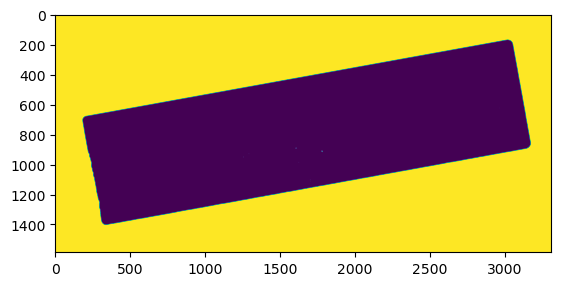

In [19]:
plt.imshow(data < data[0, 0]+ 0.000000001)

In [20]:
data[0, 0]

0.0063095735

In [21]:
stride = 92
patch_x = 224
patch_y = patch_x
percent_covered = .9
pixels_covered = patch_x * patch_y * percent_covered
print(pixels_covered)

45158.4


In [22]:
n_x = width // stride + 1
n_y = height // stride + 1
print(n_y, n_y)

18 18


In [23]:
slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

In [24]:
patches = [(sy, sx) for sy in slices_y for sx in slices_x]
len(patches)

666

In [25]:
data_mask.shape

(1586, 3312)

In [26]:
data_mask[np.s_[1720: 18000], np.s_[3320: 3330]].shape

(0, 0)

In [27]:
patches_with_data = [p for p in patches 
                     if (data_mask[p].sum() > pixels_covered) 
                     and (data_mask[p].shape == (patch_x, patch_y))
                    ]
len(patches_with_data)

179

In [28]:
plt.imshow(X[patches_with_data[1_000]], vmin=0, vmax=.5)

IndexError: list index out of range

In [29]:
patches_with_data[100]

(slice(736, 960, None), slice(736, 960, None))

In [30]:
def get_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

patch_records = [{'x_start': sx.start,
                  'x_stop': sx.stop,
                  'y_start': sy.start,
                  'y_stop': sy.stop,
                  'epsg': p['crs'].to_epsg(),
                  'burst_id': 'T064_135524_IW1',
                  'geometry': get_geo(sx, sy, transform)} for (sy, sx) in tqdm(patches_with_data)]

100%|██████████| 179/179 [00:00<00:00, 8352.31it/s]


In [31]:
patch_records[0]

{'x_start': 2760,
 'x_stop': 2984,
 'y_start': 184,
 'y_stop': 408,
 'epsg': 32632,
 'burst_id': 'T064_135524_IW1',
 'geometry': <POLYGON ((500565 5022885, 500565 5016165, 493845 5016165, 493845 5022885, 5...>}

<Axes: >

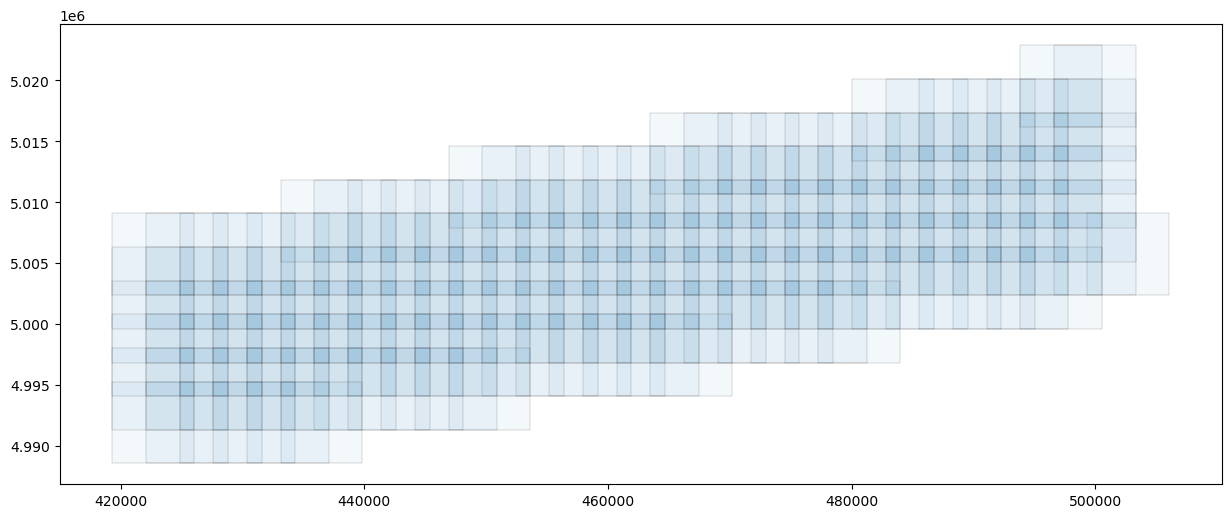

In [32]:
df_patches = gpd.GeoDataFrame(patch_records)
df_patches['patch_id'] = df_patches.index
ax = df_patches.exterior.plot(figsize=(15, 10), color='black', lw=.1, alpha=1)
df_patches.plot(figsize=(15, 10), alpha=.05, ax=ax)


# Serializing all the Bursts

In [37]:
burst_ids = df_clean.jpl_burst_id.unique()

def get_utm_geo(sx, sy, transform):
    xmin, ymin = xy(transform, sy.start, sx.start)
    xmax, ymax = xy(transform, sy.stop, sx.stop)
    return box(xmin, ymin, xmax, ymax)

def get_patch_dataframe_utm(burst_id: str, 
                            stride = 92,
                            patch_x = 224,
                            patch_y = 224,
                            percent_covered = .95,
                            serialize=False,
                            burst_patch_dir = Path('burst_patch_data_v3')) -> gpd.GeoDataFrame:
        
    burst_patch_dir = Path(burst_patch_dir)
    burst_patch_dir.mkdir(exist_ok=True, parents=True)

    out_path = burst_patch_dir / f'{burst_id}.parquet'

    if out_path.exists() and serialize:
       return out_path
    pixels_covered = patch_x * patch_y * percent_covered

    pixels_covered_per_patch = patch_x * patch_y * percent_covered
    df_ts = df_clean[df_clean['jpl_burst_id'] == burst_id].reset_index(drop=True)
    path_vv = df_ts.rtc_s1_vv_url[0]
    sample_paths = f"{data_dir}/{path_vv.split('/')[-1].split('_')[3]}/{path_vv.split('/')[-1].replace('VV', 'stack')}"

    with rasterio.open(sample_paths) as ds:
        data_mask = ds.read_masks(1).astype(bool)
        width = ds.width
        height = ds.height
        transform = ds.transform
        p = ds.profile
    
    n_x = width // stride + 1
    n_y = height // stride + 1
    
    slices_x = [np.s_[i * stride: i * stride + patch_x] for i in range(n_x)]
    slices_y = [np.s_[i * stride: i * stride + patch_x] for i in range(n_y)]

    patches = [(sy, sx) for sy in slices_y for sx in slices_x]
    patches_with_data = [p for p in patches if (data_mask[p].sum() > pixels_covered_per_patch)
                         and (data_mask[p].shape == (patch_x, patch_y))]

    patch_records = [{'x_start': sx.start,
                      #'x_stop': sx.stop,
                      'y_start': sy.start,
                      #'y_stop': sy.stop,
                      #'epsg': p['crs'].to_epsg(),
                      'jpl_burst_id': burst_id,
                      #'geometry': get_geo(sx, sy, transform)
                     } for (sy, sx) in patches_with_data]

    #df = gpd.GeoDataFrame.from_dict(patch_records, crs=p['crs'])
    df = pd.DataFrame(patch_records)
    if not serialize:
        return df
    else:
        # df.to_json(out_path)
        df.to_parquet(out_path)
        return out_path
        

In [ ]:
#get_patch_dataframe_utm(burst_ids[1242])

In [38]:
from mpire import WorkerPool

with WorkerPool(n_jobs=20, use_dill=True) as pool:
    dfs = pool.map(
        get_patch_dataframe_utm, (bid for bid in burst_ids), 
        progress_bar=True, progress_bar_style='notebook', 
        iterable_len=len(burst_ids)
    ) 
df_all_patches = pd.concat(dfs, ignore_index=True)
out_file = f"jk_patch_data/burst_patch_data_224.parquet"
df_all_patches.to_parquet(out_file, engine="pyarrow")

  0%|          | 0/178 [00:00<?, ?it/s]

In [36]:
from mpire import WorkerPool
from functools import partial
import os, pandas as pd

os.makedirs("jk_patch_data", exist_ok=True)

patch_size_list = [224]

for patch_size in patch_size_list:
    # Pre-bind the constant kwargs ----------------------------------------
    patch_fn = partial(
        get_patch_dataframe_utm,
        patch_x=patch_size,
        patch_y=patch_size,
        stride=92,                  # add more constants if you wish
        # data_dir="/path/to/rtc",
    )

    with WorkerPool(n_jobs=20, use_dill=True) as pool:
        dfs = pool.map(
            patch_fn,
            burst_ids,                     # iterable of burst IDs
            iterable_len=len(burst_ids),
            chunk_size=1,              # ← one task per ID

            progress_bar=True,
            progress_bar_style="notebook",
        )

    # Keep only non-empty results
    dfs = [df for df in dfs if df is not None and not df.empty]
    if not dfs:
        print(f"No valid patches for size {patch_size}")
        continue

    df_all_patches = pd.concat(dfs, ignore_index=True)
    out_file = f"jk_patch_data/burst_patch_data_{patch_size}.parquet"
    df_all_patches.to_parquet(out_file, engine="pyarrow")
    print(f"✅  saved {len(df_all_patches):,} patches → {out_file}")


  0%|          | 0/178 [00:00<?, ?it/s]

ValueError: ('Lengths must match to compare', (13116,), (1,))

In [32]:
dfs

[      x_start  y_start     jpl_burst_id
 0        2920      220  T001-000055-IW1
 1        2940      220  T001-000055-IW1
 2        2820      240  T001-000055-IW1
 3        2840      240  T001-000055-IW1
 4        2860      240  T001-000055-IW1
 ...       ...      ...              ...
 4317      400     1340  T001-000055-IW1
 4318      420     1340  T001-000055-IW1
 4319      440     1340  T001-000055-IW1
 4320      460     1340  T001-000055-IW1
 4321      360     1360  T001-000055-IW1
 
 [4322 rows x 3 columns],
       x_start  y_start     jpl_burst_id
 0        2920      220  T001-000056-IW1
 1        2940      220  T001-000056-IW1
 2        2820      240  T001-000056-IW1
 3        2840      240  T001-000056-IW1
 4        2860      240  T001-000056-IW1
 ...       ...      ...              ...
 4325      420     1340  T001-000056-IW1
 4326      440     1340  T001-000056-IW1
 4327      460     1340  T001-000056-IW1
 4328      340     1360  T001-000056-IW1
 4329      360     1360  T001

In [ ]:
# # dfs_utm = list(map(get_patch_dataframe_utm, tqdm(burst_ids[:])))

# with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
#     out_paths = list(tqdm(executor.map(get_patch_dataframe_utm, 
#                                      burst_ids[:]), 
#                         total=len(burst_ids[:])))


In [24]:
df_all_patches = pd.concat(dfs, axis=0)
df_all_patches

""


In [37]:
compression_options = dict(method='zip', archive_name=f'patch_data_v2.json')
df_all_patches.to_json('patch_data_v2.json.zip', compression=compression_options, index=False, indent=2, orient='records')

In [34]:
import os
os.makedirs('jk_patch_data', exist_ok=True)
df_all_patches.to_parquet(f'jk_patch_data/burst_patch_data_64.pqt', engine='pyarrow')

## Checking we can stream data using our dataframe

In [ ]:
all_burst_ids = df_rtc_meta.jpl_burst_id.unique()
df_patches = pd.read_parquet('burst_patch_data.pqt',
                              filters=[('jpl_burst_id', '=', all_burst_ids[2000])])

In [ ]:

utm_record = df_patches.iloc[40].to_dict()
ind = (df_rtc_meta['jpl_burst_id'] == utm_record['jpl_burst_id'])
df_ts = df_rtc_meta[ind].reset_index(drop=True)

In [ ]:
PATCH_IND = 30
RASTER_IND = 30

PATH_SIZE = 224

r = utm_record
rows = [r['y_start'], r['y_start'] + PATH_SIZE]
cols = [r['x_start'], r['x_start'] + PATH_SIZE]
window = Window.from_slices(rows=rows, cols=cols)

with rasterio.open(df_ts.rtc_s1_vh_url[RASTER_IND]) as ds:
    X_p = ds.read(1, window=window)

In [ ]:
plt.imshow(X_p, vmin=0, vmax=.15)